## Clonando el repositorio

In [ ]:
!git clone --recursive https://github.com/v-iashin/BMT.git
%cd BMT/

## Preparando el entorno


In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_23.1.0-1-Linux-x86_64.sh -q --show-progress
!bash ./Miniconda3-py37_23.1.0-1-Linux-x86_64.sh -b -f -p /usr/local

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install cryptography==38.0.4
!pip install pyopenssl --upgrade

In [ ]:
import os
from pathlib import Path
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from sample.single_video_prediction import get_video_duration

In [ ]:
# Extracion de caracteristicas
!export PIP_DEFAULT_TIMEOUT=100
!conda env create -f ./submodules/video_features/conda_env_i3d.yml
!conda env create -f ./submodules/video_features/conda_env_vggish.yml
# Modelo de lenguaje Spacy
!/usr/local/envs/bmt/bin/python -m spacy download en

## Descargando los Checkpoints

In [ ]:
!wget https://a3s.fi/swift/v1/AUTH_a235c0f452d648828f745589cde1219a/bmt/glove.840B.300d.zip -q --show-progress
!wget https://storage.googleapis.com/audioset/vggish_model.ckpt -q --show-progress

!mkdir .vector_cache
!mv glove.840B.300d.zip ./.vector_cache/
!mv vggish_model.ckpt ./submodules/video_features/models/vggish/checkpoints/

## Cargando la ruta a los videos en Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extraccion de caracteristicas

In [ ]:
# Directorio que contiene los videos
video_directory = '/content/drive/MyDrive/HSD/HSD_Videos/'

# Extensión de archivo
file_extension = '.mp4'

# Lista para almacenar las rutas de los videos
VIDEO_PATHS = []

# Recorre los archivos en el directorio
for filename in os.listdir(video_directory):
    if filename.endswith(file_extension):
        video_path = os.path.join(video_directory, filename)
        VIDEO_PATHS.append(video_path)

# Directorio para almacenar las características
FEATURES_CACHE_PATH = '/content/drive/MyDrive/HSD/Caracteristicas/'

for video_path in VIDEO_PATHS:
    # Preparar las rutas de salida para las características de audio y video
    VIDEO_DURATION = get_video_duration(video_path)
    FEATURES_PATH_STUB = os.path.join(FEATURES_CACHE_PATH, Path(video_path).stem)
    FEATURE_PATH_VGGISH = f'{FEATURES_PATH_STUB}_vggish.npy'
    FEATURE_PATH_RGB = f'{FEATURES_PATH_STUB}_rgb.npy'
    FEATURE_PATH_FLOW = f'{FEATURES_PATH_STUB}_flow.npy'


    # Extraer características de video
    !cd ./submodules/video_features && /usr/local/envs/i3d/bin/python main.py \
        --feature_type i3d \
        --on_extraction save_numpy \
        --device_ids 0 \
        --extraction_fps 25 \
        --video_paths {video_path} \
        --output_path {FEATURES_CACHE_PATH}

    # Extraer características de audio
    !cd ./submodules/video_features && /usr/local/envs/vggish/bin/python main.py \
        --feature_type vggish \
        --on_extraction save_numpy \
        --device_ids 0 \
        --video_paths {video_path} \
        --output_path {FEATURES_CACHE_PATH}

## Importacion de librerias necesarias

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
from IPython.display import HTML, display

## Carga de caracteristicas

In [ ]:
# Directorio que contiene los videos
video_directory = '/content/drive/MyDrive/HSD/HSD_Videos/'

# Extensión de archivo
file_extension = '.mp4'

# Lista para almacenar las rutas de los videos
VIDEO_PATHS = []

# Recorre los archivos en el directorio
for filename in os.listdir(video_directory):
    if filename.endswith(file_extension):
        video_path = os.path.join(video_directory, filename)
        VIDEO_PATHS.append(video_path)

# Directorio que contiene las características
FEATURES_CACHE_PATH = '/content/drive/MyDrive/HSD/Caracteristicas/'

video_features = []
video_labels = []

for video_path in VIDEO_PATHS:
    # Preparar la ruta de salida para las características de video
    FEATURES_PATH_STUB = os.path.join(FEATURES_CACHE_PATH, os.path.splitext(os.path.basename(video_path))[0])
    FEATURE_PATH_RGB = f'{FEATURES_PATH_STUB}_rgb.npy'
    FEATURE_PATH_FLOW = f'{FEATURES_PATH_STUB}_flow.npy'
    FEATURE_PATH_SPEECH = f'{FEATURES_PATH_STUB}_vggish.npy'

    # Carga las características de video en memoria
    video_feature_rgb = np.load(FEATURE_PATH_RGB)
    video_feature_flow = np.load(FEATURE_PATH_FLOW)
    video_feature_speech = np.load(FEATURE_PATH_SPEECH)

    # Asegura que todas las matrices tengan la misma longitud en el eje 0
    min_length = min(len(video_feature_rgb), len(video_feature_flow), len(video_feature_speech))
    video_feature_rgb = video_feature_rgb[:min_length]
    video_feature_flow = video_feature_flow[:min_length]
    video_feature_speech = video_feature_speech[:min_length]

    # Concatena las características de video RGB, Flow y Speech
    video_feature = np.concatenate((video_feature_rgb, video_feature_flow, video_feature_speech), axis=1)

    # Obtener el número de características en el video
    num_features = video_feature.shape[0]

    # Extraer el número del nombre de la característica
    feature_number = int(os.path.basename(video_path).split("_")[0])

    # Crear etiquetas únicas para las características del video
    labels = [f'{feature_number}' for idx in range(num_features)]

    video_features.append(video_feature)
    video_labels.extend(labels)

# Convierte la lista de características de video en una matriz numpy
video_features = np.vstack(video_features)


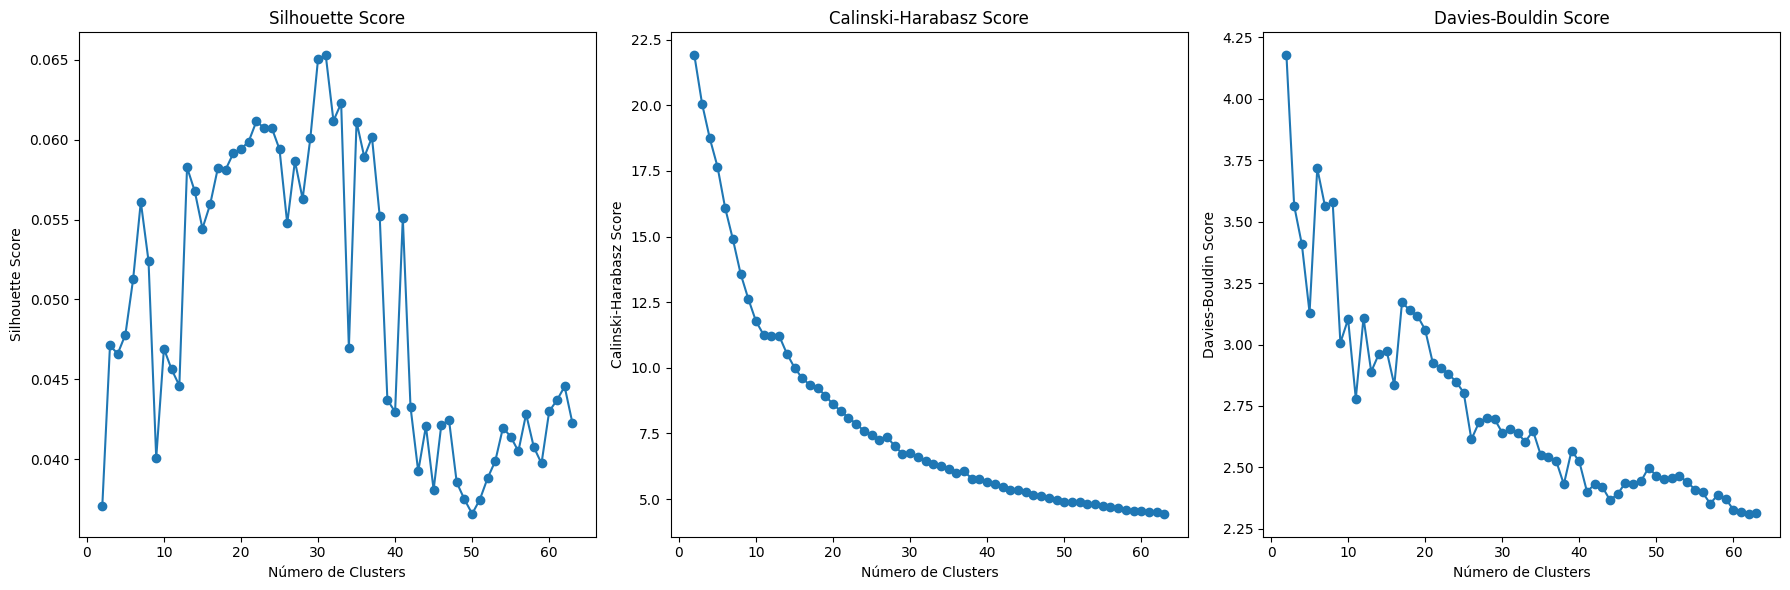

In [ ]:
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

minK = 2
maxK = 64

for i in range(minK, maxK):
    n_clusters = i
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='random', n_init=10)
    video_clusters = kmeans.fit_predict(video_features)

    # Calcular Silhouette Score
    silhouette_avg = silhouette_score(video_features, video_clusters)
    silhouette_scores.append(silhouette_avg)

    # Calcular Calinski-Harabasz Score
    ch_score = calinski_harabasz_score(video_features, video_clusters)
    calinski_harabasz_scores.append(ch_score)

    # Calcular Davies-Bouldin Score
    db_score = davies_bouldin_score(video_features, video_clusters)
    davies_bouldin_scores.append(db_score)

# Graficar Silhouette Score
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(range(minK, maxK), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

# Graficar Calinski-Harabasz Score
plt.subplot(132)
plt.plot(range(minK, maxK), calinski_harabasz_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score')

# Graficar Davies-Bouldin Score
plt.subplot(133)
plt.plot(range(minK, maxK), davies_bouldin_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score')

plt.tight_layout()
plt.show()

## Escalado y reduccion de dimensionalidad

In [ ]:
# Escala las características
scaler = StandardScaler()
video_features_scaled = scaler.fit_transform(video_features)

# Aplica t-SNE para reducir la dimensionalidad a 2 dimensiones
tsne = TSNE(n_components=2, random_state=0)
video_features_tsne = tsne.fit_transform(video_features_scaled)

## Vizualización del agrupamiento con diferente cantidad de clusters

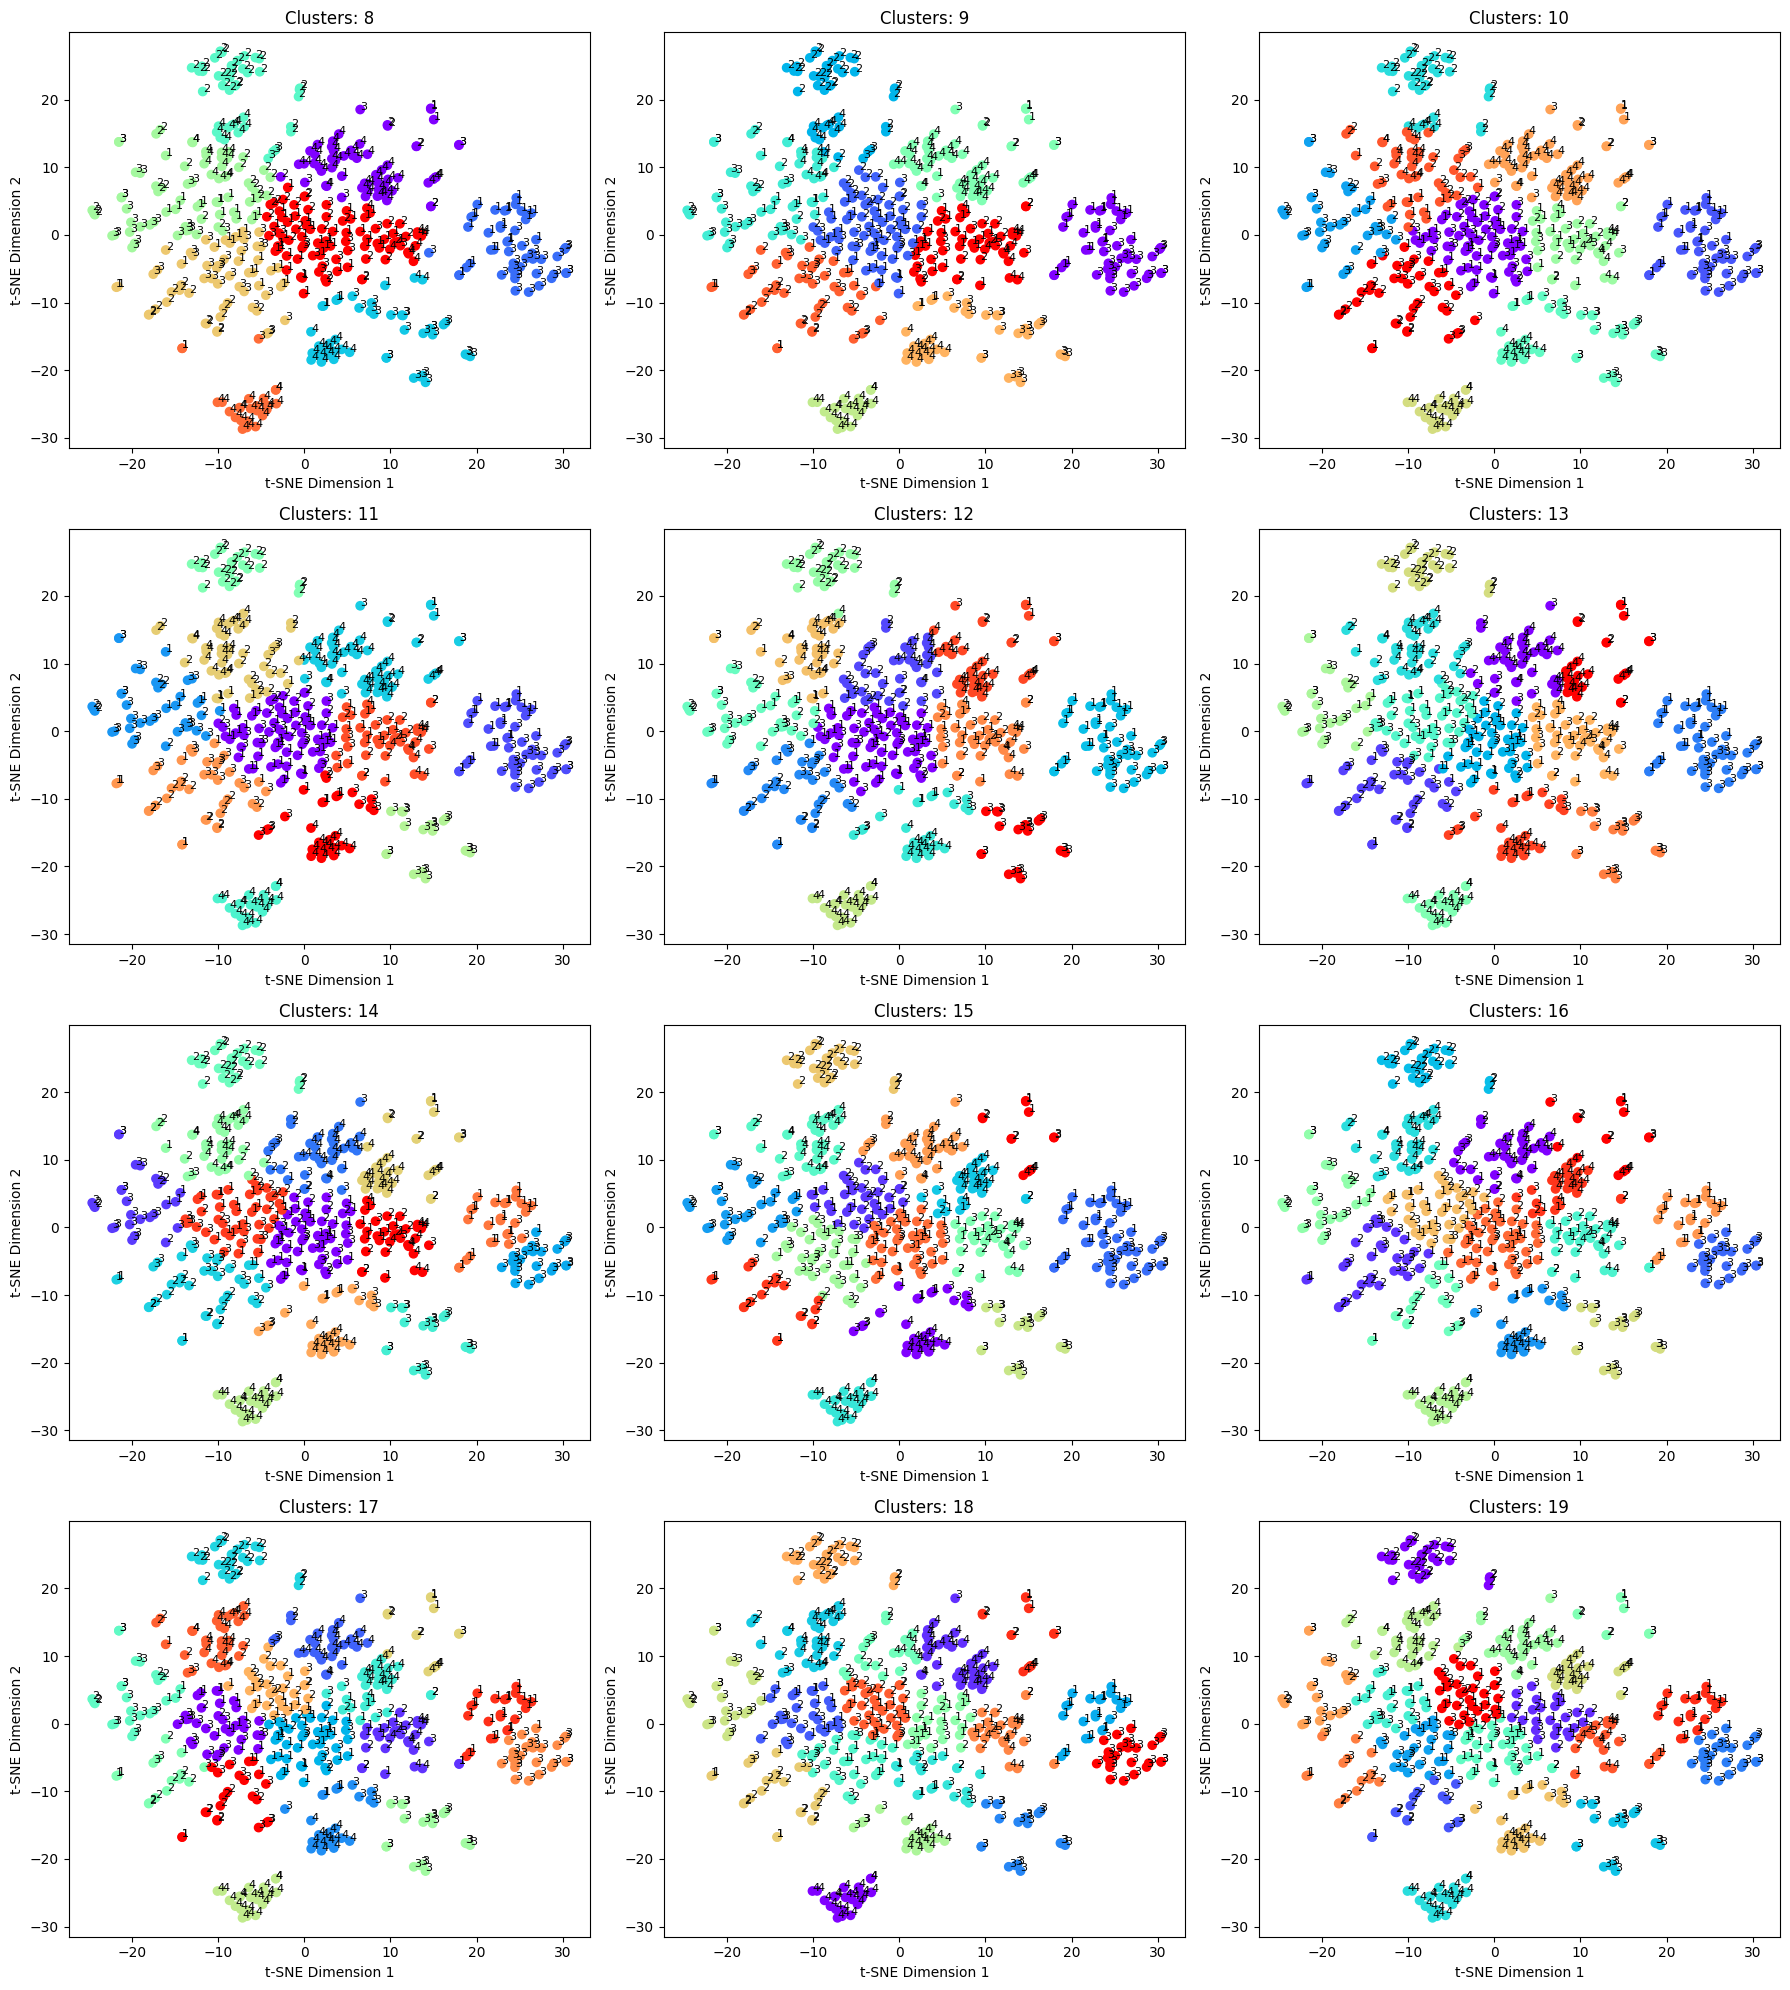

In [ ]:

min_clusters = 8
max_clusters = 19

# Calcular el número de filas y columnas necesarios
num_clusters = max_clusters - min_clusters + 1
num_rows = (num_clusters + 2) // 3  # Dividir por 3 y redondear hacia arriba
num_columns = min(num_clusters, 3)

# Crear una figura con subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(18, 5 * num_rows))

# Aplicar K-Means y visualizar clusters en subplots
for i in range(min_clusters, max_clusters + 1):
    n_clusters = i
    row_index = (i - min_clusters) // 3
    col_index = (i - min_clusters) % 3

    # Aplicar K-Means a las características de video reducidas por t-SNE
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='k-means++', n_init=10)
    video_clusters = kmeans.fit_predict(video_features_tsne)

    # Visualizar los clusters en 2D con etiquetas de características
    scatter = axs[row_index, col_index].scatter(video_features_tsne[:, 0], video_features_tsne[:, 1], c=video_clusters, cmap='rainbow')
    axs[row_index, col_index].set_title(f'Clusters: {n_clusters}')
    axs[row_index, col_index].set_xlabel('t-SNE Dimension 1')
    axs[row_index, col_index].set_ylabel('t-SNE Dimension 2')

    # Agregar etiquetas de características a los puntos en el gráfico
    for j, label in enumerate(video_labels):
        x, y = video_features_tsne[j, 0], video_features_tsne[j, 1]
        axs[row_index, col_index].text(x, y, label, fontsize=8)

# Ajustar el espaciado entre subplots y mostrar la figura
plt.tight_layout()
plt.show()


## Pruebas de rendimiento de K-means con reduccion de dimensionalidad

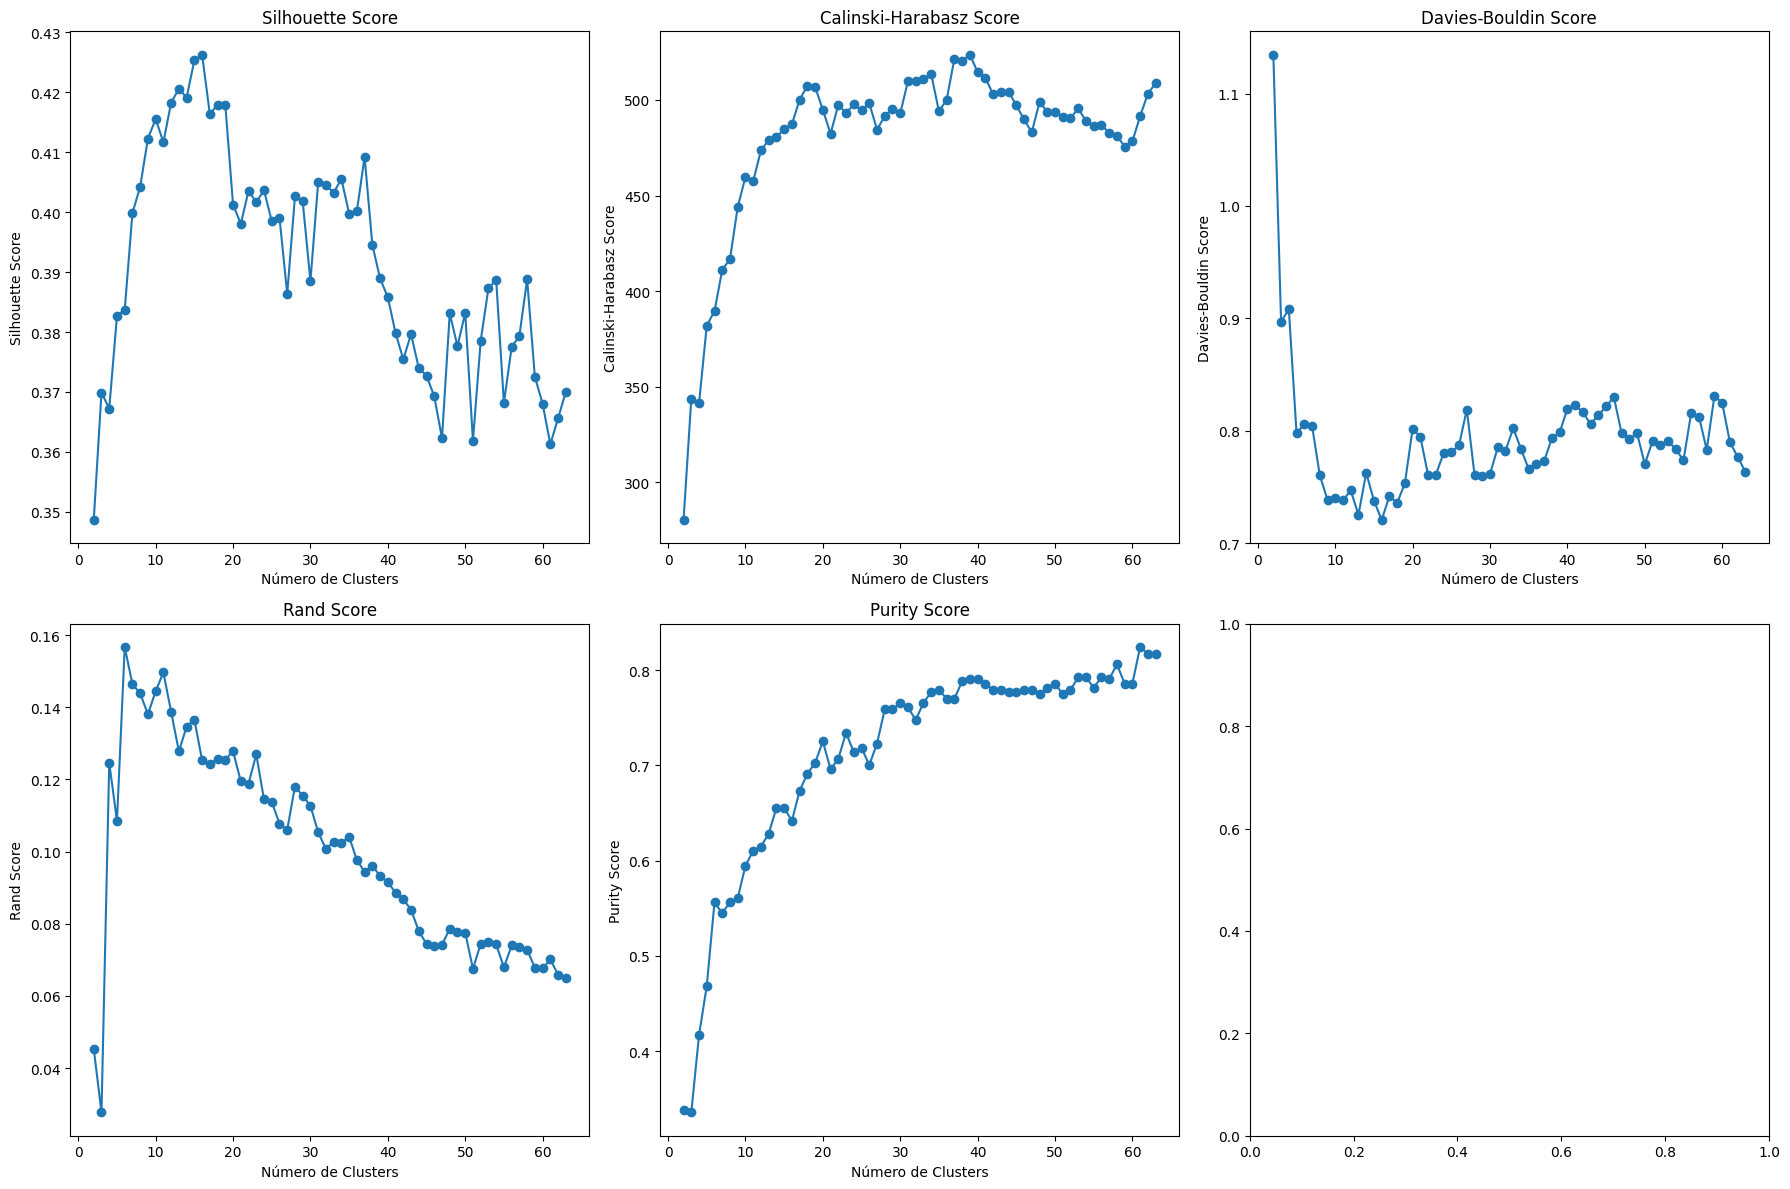

In [ ]:
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
rand_scores = []
purity_scores = []

minK = 2
maxK = 64

# Crea una figura con subgráficos de 5 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i in range(minK, maxK):
    n_clusters = i
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='random', n_init=10)
    video_clusters = kmeans.fit_predict(video_features_tsne)

    # Calcular Silhouette Score
    silhouette_avg = silhouette_score(video_features_tsne, video_clusters)
    silhouette_scores.append(silhouette_avg)

    # Calcular Calinski-Harabasz Score
    ch_score = calinski_harabasz_score(video_features_tsne, video_clusters)
    calinski_harabasz_scores.append(ch_score)

    # Calcular Davies-Bouldin Score
    db_score = davies_bouldin_score(video_features_tsne, video_clusters)
    davies_bouldin_scores.append(db_score)

    # Calcular el Rand Index Score
    rand_index = adjusted_rand_score(video_labels, video_clusters)
    rand_scores.append(rand_index)

    # Calcula la matriz de contingencia entre etiquetas reales y de clúster
    contingency_mat = contingency_matrix(video_labels, video_clusters)

    # Calcula el Purity Score
    purity = np.sum(np.max(contingency_mat, axis=0)) / np.sum(contingency_mat)
    purity_scores.append(purity)

# Graficar Silhouette Score
axes[0, 0].plot(range(minK, maxK), silhouette_scores, marker='o')
axes[0, 0].set_xlabel('Número de Clusters')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score')

# Graficar Calinski-Harabasz Score
axes[0, 1].plot(range(minK, maxK), calinski_harabasz_scores, marker='o')
axes[0, 1].set_xlabel('Número de Clusters')
axes[0, 1].set_ylabel('Calinski-Harabasz Score')
axes[0, 1].set_title('Calinski-Harabasz Score')

# Graficar Davies-Bouldin Score
axes[0, 2].plot(range(minK, maxK), davies_bouldin_scores, marker='o')
axes[0, 2].set_xlabel('Número de Clusters')
axes[0, 2].set_ylabel('Davies-Bouldin Score')
axes[0, 2].set_title('Davies-Bouldin Score')

# Graficar Rand Score
axes[1, 0].plot(range(minK, maxK), rand_scores, marker='o')
axes[1, 0].set_xlabel('Número de Clusters')
axes[1, 0].set_ylabel('Rand Score')
axes[1, 0].set_title('Rand Score')

# Graficar Purity Score
axes[1, 1].plot(range(minK, maxK), purity_scores, marker='o')
axes[1, 1].set_xlabel('Número de Clusters')
axes[1, 1].set_ylabel('Purity Score')
axes[1, 1].set_title('Purity Score')

plt.tight_layout()
plt.show()

In [ ]:
# Calcular los índices de los valores máximos y mínimos
max_silhouette_index = silhouette_scores.index(max(silhouette_scores))
max_calinski_index = calinski_harabasz_scores.index(max(calinski_harabasz_scores))
min_davies_index = davies_bouldin_scores.index(min(davies_bouldin_scores))

# Crear una tabla HTML
table_data = []
for i in range(minK, maxK):
    row = [i, silhouette_scores[i - minK], calinski_harabasz_scores[i - minK], davies_bouldin_scores[i - minK]]

    # Resaltar valores máximos y mínimos
    if i == max_silhouette_index + minK:
        row[1] = f'<b><font color="red">{row[1]:.4f}</font></b>'
    if i == max_calinski_index + minK:
        row[2] = f'<b><font color="red">{row[2]:.4f}</font></b>'
    if i == min_davies_index + minK:
        row[3] = f'<b><font color="red">{row[3]:.4f}</font></b>'

    table_data.append(row)

table_html = '<table><tr><th>Número de Clusters</th><th>Silhouette Score</th><th>Calinski-Harabasz Score</th><th>Davies-Bouldin Score</th></tr>'
for row in table_data:
    table_html += '<tr>'
    for cell in row:
        table_html += f'<td>{cell}</td>'
    table_html += '</tr>'
table_html += '</table>'

# Mostrar la tabla HTML
display(HTML(table_html))


## Vizualizacion del Cluster con mejor puntuacion

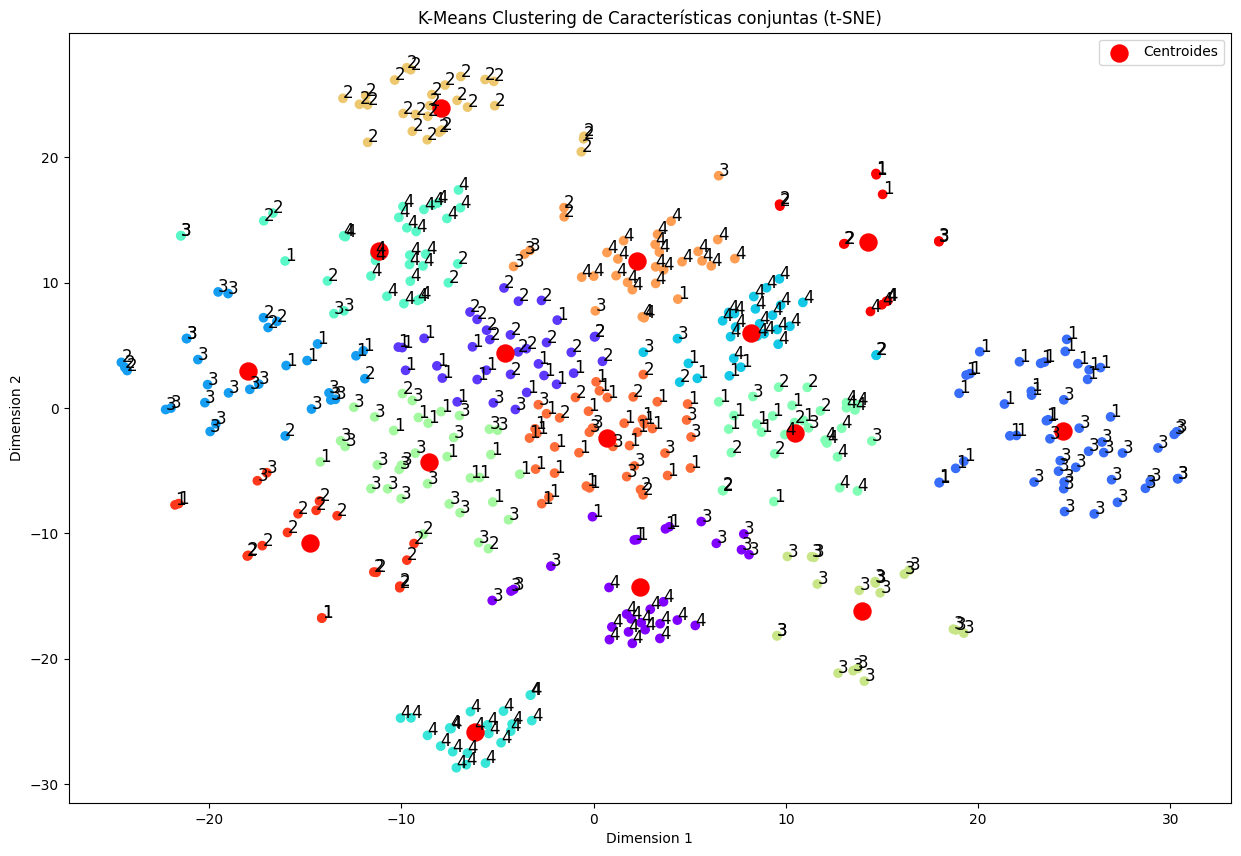

In [ ]:
# Número de clusters
n_clusters = 15

# Aplica K-Means a las características de video reducidas por t-SNE
kmeans = KMeans(n_clusters=n_clusters, random_state=0,
                init='k-means++', n_init=10)
video_clusters = kmeans.fit_predict(video_features_tsne)

# Obtiene los centroides de los clústeres
centroids = kmeans.cluster_centers_

# Visualiza los clusters en 2D con etiquetas de características
plt.figure(figsize=(15, 10))
scatter = plt.scatter(video_features_tsne[:, 0], video_features_tsne[:, 1],
                      c=video_clusters, cmap='rainbow')
plt.title('K-Means Clustering de Características conjuntas (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Agregar etiquetas de características a los puntos en el gráfico
for i, label in enumerate(video_labels):
    x, y = video_features_tsne[i, 0], video_features_tsne[i, 1]
    plt.text(x, y, label, fontsize=12)

# Marcar los centroides de los clústeres con círculos rojos
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='o',
            s=150, label='Centroides')

plt.legend()
plt.show()


## Carga, estandarizacion y reducion de dimensionalidad a las caracteristicas rgb, flow y speech por separado

In [ ]:
# Directorio que contiene los videos
video_directory = '/content/drive/MyDrive/HSD/HSD_Videos/'

# Extensión de archivo
file_extension = '.mp4'

# Lista para almacenar las rutas de los videos
VIDEO_PATHS = []

# Recorre los archivos en el directorio
for filename in os.listdir(video_directory):
    if filename.endswith(file_extension):
        video_path = os.path.join(video_directory, filename)
        VIDEO_PATHS.append(video_path)

# Directorio que contiene las características
FEATURES_CACHE_PATH = '/content/drive/MyDrive/HSD/Caracteristicas/'


video_features_rgb = []
video_features_flow = []
video_features_speech = []
video_labels_rgb = []
video_labels_flow = []
video_labels_speech = []

for video_path in VIDEO_PATHS:
    # Preparar la ruta de salida para las características de video
    FEATURES_PATH_STUB = os.path.join(FEATURES_CACHE_PATH, os.path.splitext(os.path.basename(video_path))[0])
    FEATURE_PATH_RGB = f'{FEATURES_PATH_STUB}_rgb.npy'
    FEATURE_PATH_FLOW = f'{FEATURES_PATH_STUB}_flow.npy'
    FEATURE_PATH_SPEECH = f'{FEATURES_PATH_STUB}_vggish.npy'

    # Carga las características de video en memoria
    video_feature_rgb = np.load(FEATURE_PATH_RGB)
    video_feature_flow = np.load(FEATURE_PATH_FLOW)
    video_feature_speech = np.load(FEATURE_PATH_SPEECH)

    num_features_rgb = video_feature_rgb.shape[0]
    num_features_flow = video_feature_flow.shape[0]
    num_features_speech = video_feature_speech.shape[0]

    feature_number = int(os.path.basename(video_path).split("_")[0])

    labels_rgb = [f'{feature_number}' for idx in range(num_features_rgb)]
    labels_flow = [f'{feature_number}' for idx in range(num_features_flow)]
    labels_speech = [f'{feature_number}' for idx in range(num_features_speech)]

    video_features_rgb.append(video_feature_rgb)
    video_features_flow.append(video_feature_flow)
    video_features_speech.append(video_feature_speech)
    video_labels_rgb.extend(labels_rgb)
    video_labels_flow.extend(labels_flow)
    video_labels_speech.extend(labels_speech)

# Convierte la lista de características de video en una matriz numpy
video_features_rgb = np.vstack(video_features_rgb)
video_features_flow = np.vstack(video_features_flow)
video_features_speech = np.vstack(video_features_speech)

# Escala las características
scaler = StandardScaler()
video_features_rgb_scaled = scaler.fit_transform(video_features_rgb)
video_features_flow_scaled = scaler.fit_transform(video_features_flow)
video_features_speech_scaled = scaler.fit_transform(video_features_speech)

# Aplica t-SNE para reducir la dimensionalidad a 2 dimensiones
tsne = TSNE(n_components=2, random_state=0)
video_features_rgb_tsne = tsne.fit_transform(video_features_rgb_scaled)
video_features_flow_tsne = tsne.fit_transform(video_features_flow_scaled)
video_features_speech_tsne = tsne.fit_transform(video_features_speech_scaled)



## Visualizacion y pruebas de rendimiento cluster de las caracteristicas rgb, flow y speech por separado

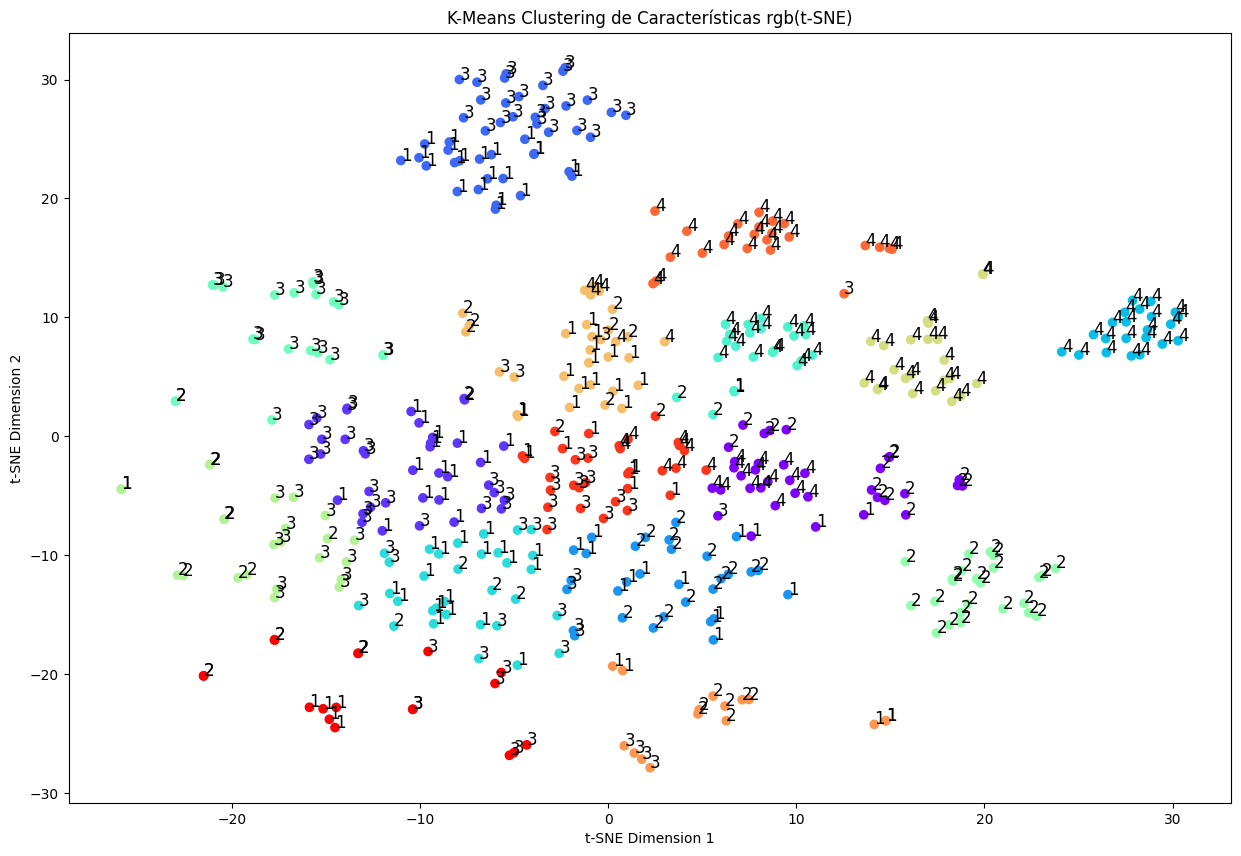

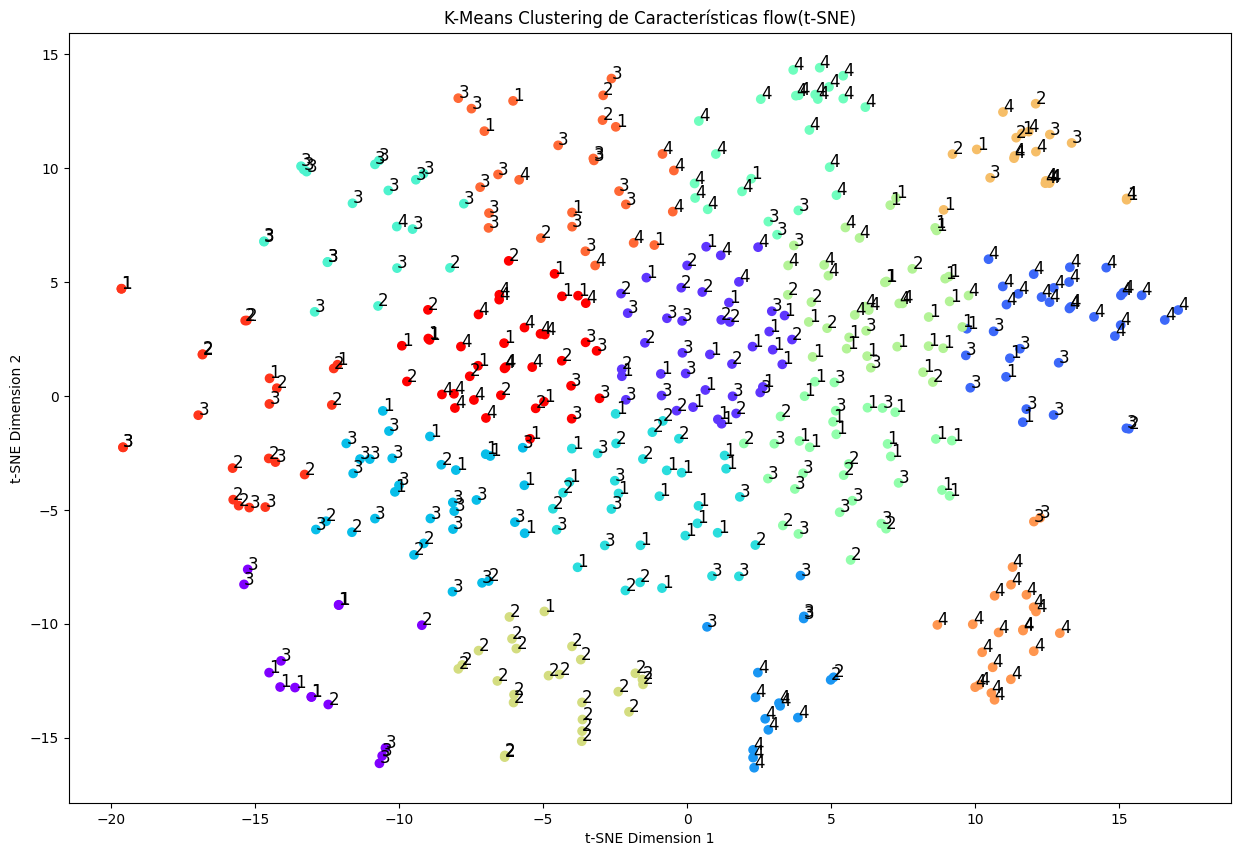

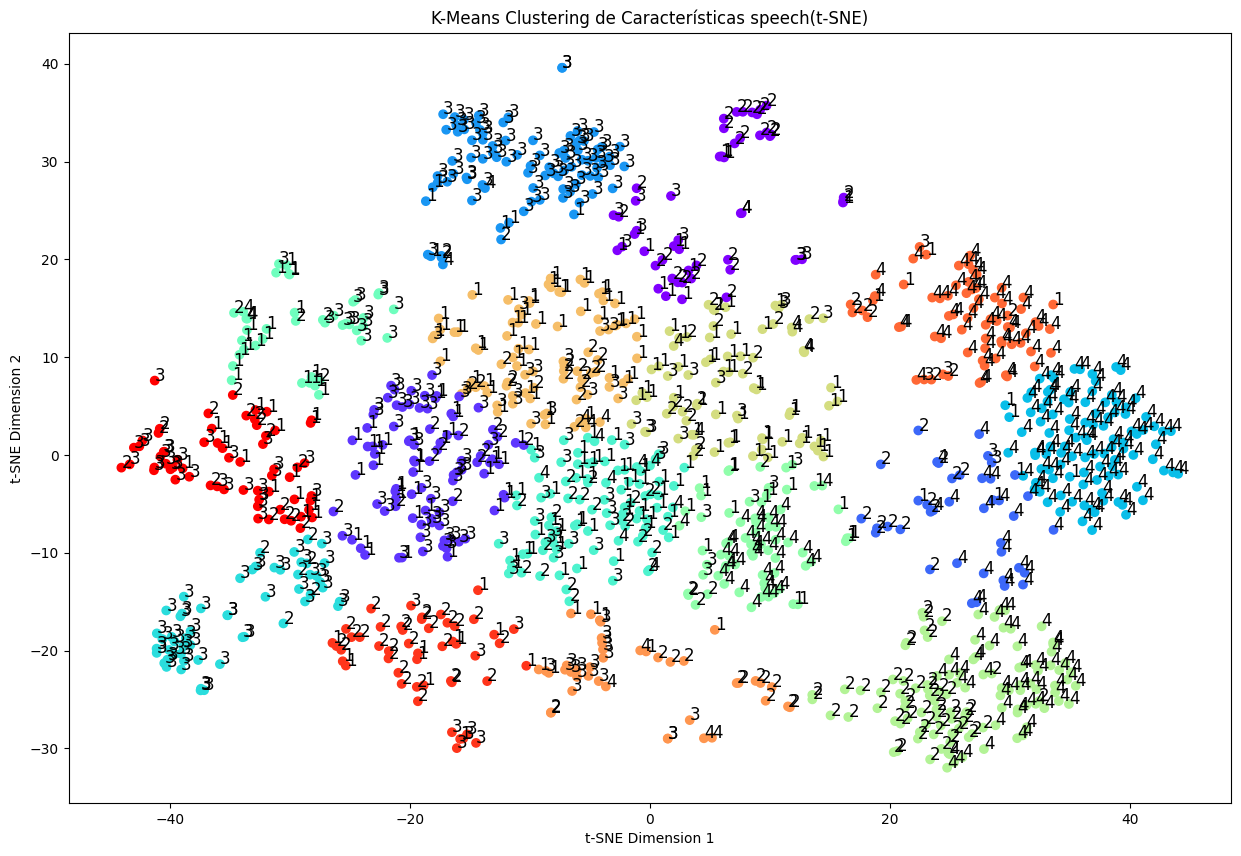

In [ ]:
# Número de clusters
n_clusters = 16

# Aplica K-Means a las características de video reducidas por t-SNE
kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='k-means++', n_init=10)
video_clusters = kmeans.fit_predict(video_features_rgb_tsne)

# Visualiza los clusters en 2D con etiquetas de características
plt.figure(figsize=(15, 10))
scatter = plt.scatter(video_features_rgb_tsne[:, 0], video_features_rgb_tsne[:, 1], c=video_clusters, cmap='rainbow')
plt.title('K-Means Clustering de Características rgb(t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Agregar etiquetas de características a los puntos en el gráfico
for i, label in enumerate(video_labels_rgb):
    x, y = video_features_rgb_tsne[i, 0], video_features_rgb_tsne[i, 1]
    plt.text(x, y, label, fontsize=12)

plt.show()

# Aplica K-Means a las características de video reducidas por t-SNE
kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='k-means++', n_init=10)
video_clusters = kmeans.fit_predict(video_features_flow_tsne)

# Visualiza los clusters en 2D con etiquetas de características
plt.figure(figsize=(15, 10))
scatter = plt.scatter(video_features_flow_tsne[:, 0], video_features_flow_tsne[:, 1], c=video_clusters, cmap='rainbow')
plt.title('K-Means Clustering de Características flow(t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Agregar etiquetas de características a los puntos en el gráfico
for i, label in enumerate(video_labels_flow):
    x, y = video_features_flow_tsne[i, 0], video_features_flow_tsne[i, 1]
    plt.text(x, y, label, fontsize=12)

plt.show()

# Aplica K-Means a las características de video reducidas por t-SNE
kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='k-means++', n_init=10)
video_clusters = kmeans.fit_predict(video_features_speech_tsne)

# Visualiza los clusters en 2D con etiquetas de características
plt.figure(figsize=(15, 10))
scatter = plt.scatter(video_features_speech_tsne[:, 0], video_features_speech_tsne[:, 1], c=video_clusters, cmap='rainbow')
plt.title('K-Means Clustering de Características speech(t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Agregar etiquetas de características a los puntos en el gráfico
for i, label in enumerate(video_labels_speech):
    x, y = video_features_speech_tsne[i, 0], video_features_speech_tsne[i, 1]
    plt.text(x, y, label, fontsize=12)

plt.show()

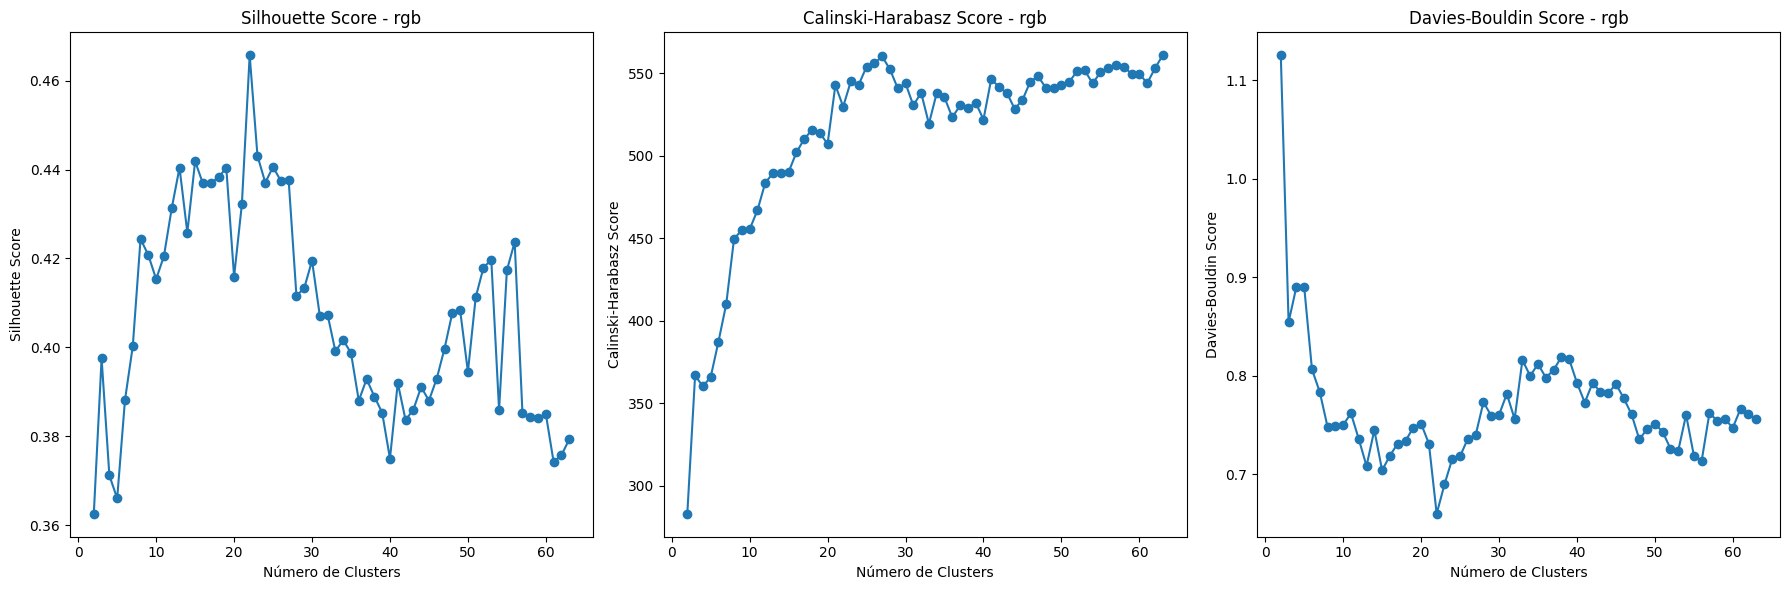

In [ ]:
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

minK = 2
maxK = 64

for i in range(minK, maxK):
    n_clusters = i
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='random', n_init=10)
    video_clusters = kmeans.fit_predict(video_features_rgb_tsne)

    # Calcular Silhouette Score
    silhouette_avg = silhouette_score(video_features_rgb_tsne, video_clusters)
    silhouette_scores.append(silhouette_avg)

    # Calcular Calinski-Harabasz Score
    ch_score = calinski_harabasz_score(video_features_rgb_tsne, video_clusters)
    calinski_harabasz_scores.append(ch_score)

    # Calcular Davies-Bouldin Score
    db_score = davies_bouldin_score(video_features_rgb_tsne, video_clusters)
    davies_bouldin_scores.append(db_score)

# Graficar Silhouette Score
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(range(minK, maxK), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score - rgb')

# Graficar Calinski-Harabasz Score
plt.subplot(132)
plt.plot(range(minK, maxK), calinski_harabasz_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score - rgb')

# Graficar Davies-Bouldin Score
plt.subplot(133)
plt.plot(range(minK, maxK), davies_bouldin_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score - rgb')

plt.tight_layout()
plt.show()